In [3]:
# Dataset
from sklearn.datasets import load_diabetes

# Basics
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from sklearn.ensemble import RandomForestRegressor

# Helpful:
from sklearn.model_selection import train_test_split

# Path setup
import sys
import os

sys.path.append("/home/dchen/Random_Forest_Weights/")
# my functions:
from src_rf.methods.calc_mean import *
from src_rf.methods.calc_weights import *
from src_rf.methods.calc_dist import *

### 1. Load Data

In [4]:
df = pd.read_csv("/home/dchen/Random_Forest_Weights/src_rf/data/energy_data_hourly.csv"
                 , index_col = 'datetime', parse_dates=True)
df.index = pd.to_datetime(df.index)

In [5]:
df.head()

,total_energy_usage,residual_energy_usage,pump_storage,hour,month,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
datetime,,,,,,,,,,,,
2015-01-01 00:00:00,44.601,35.957,602.0,0,1,0,0,0,0,1,0,0
2015-01-01 01:00:00,43.455,34.642,347.0,1,1,0,0,0,0,1,0,0
2015-01-01 02:00:00,41.964,32.910,522.0,2,1,0,0,0,0,1,0,0
2015-01-01 03:00:00,40.618,31.548,1229.0,3,1,0,0,0,0,1,0,0
2015-01-01 04:00:00,39.936,30.775,1821.0,4,1,0,0,0,0,1,0,0


In [6]:
df.shape

(68184, 12)

### 2. Train Test Split

In [7]:
X = df.drop('total_energy_usage', axis = 1).values
y = df['total_energy_usage'].values

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=False, random_state=42)

### 3. Random Forest

In [18]:
bootstrap = False
max_samples = 0.8

In [19]:
rf = RandomForestRegressor(
    bootstrap=bootstrap, max_samples = max_samples, verbose=0, n_jobs=-1, random_state=42
)

In [20]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_samples=0.8, n_jobs=-1,
                      random_state=42)

### 3. Calculate Weights Random Forest

In [21]:
X_test[0:100,:].shape

(100, 11)

In [22]:
num_samples = X_test.shape[0]
batch_size = 50

for start_idx in range(0, num_samples, batch_size):
    end_idx = min(start_idx + batch_size, num_samples)
    batch = X_test[start_idx:end_idx]

In [23]:
X_test[13636: 13637,0]

array([53.539])

In [24]:
X_test.shape

(54548, 11)

In [25]:
rf_weights = calc_weights_rf(rf, X_train, X_test[0:100,:], bootstrap, max_samples)

100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:00<00:00,  4.20s/it]


### 4. Calc Mean with weights and normal:

In [26]:
rf_mean_weights = calc_mean_rf(rf_weights, y_train)
rf_mean_normal = rf.predict(X_test)

In [27]:
rf_mean_weights.shape
rf_mean_normal.shape

(54548,)

In [28]:
# Are the two the same?
sum(np.round(rf_mean_weights, 5) == np.round(rf_mean_normal[0:100], 5))

100

### 5. Calc Quantile Random Forest

In [29]:
rf_cdfs = calc_dist_rf(rf_weights, y_train)

In [30]:
rf_median = calc_quantile_rf(rf_cdfs, 0.5, y_train)

### 6. Weights Analysis


In [37]:
rf_weights.shape

(100, 100, 54547)

<AxesSubplot:>

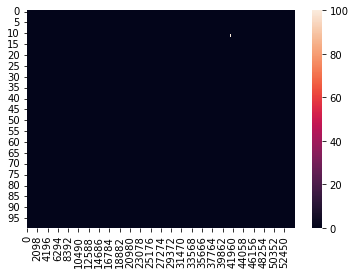

In [38]:
sns.heatmap(np.sum(rf_weights, axis = 0))

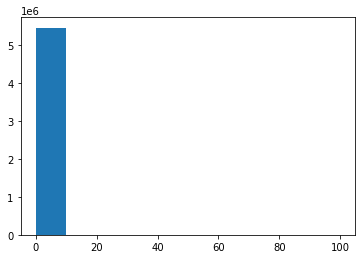

In [39]:
plt.hist(np.sum(rf_weights, axis = 0).flatten(), bins = 10)
plt.show()

In [40]:
np.mean(rf_weights, axis = 0).shape

(100, 54547)

In [41]:
np.max(np.sum(rf_weights, axis = 0))

100.0

In [42]:
np.sum(rf_weights[0].flatten() == 1)

100

In [43]:
X_train.shape

(54547, 10)

In [44]:
rf_weights[0,0].sum()

1.0

In [45]:
rf.estimators_[0]

DecisionTreeRegressor(max_features='auto', random_state=1302015333)